## Regression Model Instability

Regression analysis allows us to estimate coefficients in a function which approximately relates multiple data sets. We hypothesize a specific form for this function and then find coefficients which fit the data well, working under the assumption that deviations from the model can be considered noise.

When building such a model, we accept that it cannot perfectly predict the dependent variable. Here we would like to evaluate the accuracy of the model not by how well it explains the dependent variable, but by how stable it is (that is, how stable the regression coefficients are) with respect to our sample data. After all, if a model is truly a good fit, it should be similar, say, for two random halves of our data set that we model individually. Otherwise, we cannot assume that the model isn't simply an artifact of the particular sample of data we happened to choose, or that it will be predictive of new data points.

We'll be using linear regressions here for illustration purposes, but the same considerations apply for all regression models. Below we define a wrapper function for the linear regression from statsmodels so we can use it later.

In [1]:
import yfinance as yf
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pandas_datareader import data as pdr
from matplotlib import style
from math import pi
import scipy.stats as stats
import scipy as sp

from statsmodels import regression, stats
import statsmodels.api as sm
import math

yf.pdr_override()

In [3]:
def linreg(X,Y):
    # Running the linear regression
    x = sm.add_constant(X) # Add a row of 1's so that our model has a constant term
    model = regression.linear_model.OLS(Y, x).fit()
    return model.params[0], model.params[1] # Return the coefficients of the linear model

## Biased Noise

The particular sample we choose for the data affects the model generated, and unevenly distributed noise can lead to an inaccurate model. Below we're drawing from a normal distribution, but because we do not have very many data points, we get a significant downward bias. If we took more measurements, both of the regression coefficients would move toward zero.

Slope: 0.009072503822685526 Intercept: -0.40207744085303815


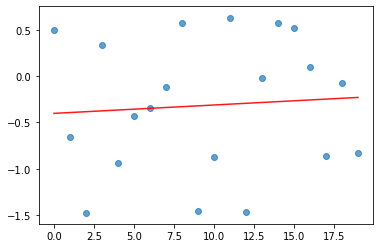

In [5]:
# Draw observations from normal distribution
np.random.seed(107) # Fix seed for random number generation
rand = np.random.randn(20)

# Conduct linear regression on the ordered list of observations
xs = np.arange(20)
a, b = linreg(xs, rand)
print('Slope:', b, 'Intercept:', a)

# Plot the raw data and the regression line
plt.scatter(xs, rand, alpha=0.7)
Y_hat = xs * b + a
plt.plot(xs, Y_hat, 'r', alpha=0.9);

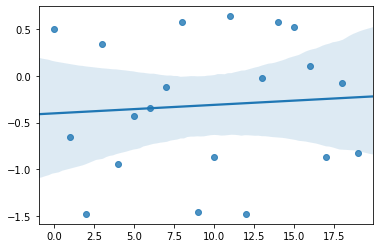

In [6]:
import seaborn

seaborn.regplot(xs, rand)

Slope: -0.0005693423631053362 Intercept: 0.009011767319021952


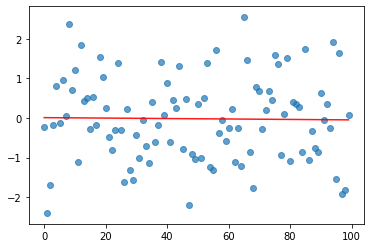

In [7]:
# Draw more observations
rand2 = np.random.randn(100)

# Conduct linear regression on the ordered list of observations
xs2 = np.arange(100)
a2, b2 = linreg(xs2, rand2)
print('Slope:', b2, 'Intercept:', a2)

# Plot the raw data and the regression line
plt.scatter(xs2, rand2, alpha=0.7)
Y_hat2 = xs2 * b2 + a2
plt.plot(xs2, Y_hat2, 'r', alpha=0.9);

Regression analysis is very sensitive to outliers. Sometimes these outliers contain information, in which case we want to take them into account; however, in cases like the above, they can simply be random noise. Although we often have many more data points than in the example above, we could have (for example) fluctuations on the order of weeks or months, which then significantly change the regression coefficients.

## Regime Changes

A regime change (or structural break) is when something changes in the process generating the data, causing future samples to follow a different distribution. Below, we can see that there is a regime change at the end of 2007, and splitting the data there results in a much better fit (in red) than a regression on the whole data set (yellow). In this case our regression model will not be predictive of future data points since the underlying system is no longer the same as in the sample. In fact, the regression analysis assumes that the errors are uncorrelated and have constant variance, which is often not be the case if there is a regime change.

[*********************100%***********************]  1 of 1 completed


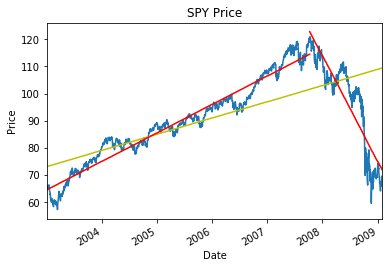

In [8]:
start_date = '2003-01-01'
end_date = '2009-02-01'
pricing = pdr.get_data_yahoo('SPY', start=start_date, end=end_date, interval = "1d")['Adj Close']

# Manually set the point where we think a structural break occurs
breakpoint = 1200
xs = np.arange(len(pricing))
xs2 = np.arange(breakpoint)
xs3 = np.arange(len(pricing) - breakpoint)

# Perform linear regressions on the full data set, the data up to the breakpoint, and the data after
a, b = linreg(xs, pricing)
a2, b2 = linreg(xs2, pricing[:breakpoint])
a3, b3 = linreg(xs3, pricing[breakpoint:])

Y_hat = pd.Series(xs * b + a, index=pricing.index)
Y_hat2 = pd.Series(xs2 * b2 + a2, index=pricing.index[:breakpoint])
Y_hat3 = pd.Series(xs3 * b3 + a3, index=pricing.index[breakpoint:])

# Plot the raw data
pricing.plot()
Y_hat.plot(color='y')
Y_hat2.plot(color='r')
Y_hat3.plot(color='r')
plt.title('SPY Price')
plt.ylabel('Price');